<a href="https://colab.research.google.com/github/JulienGremillot/OpenClassrooms_Ingenieur_Machine_Learning/blob/main/P8%20-%20Participez%20%C3%A0%20une%20comp%C3%A9tition%20Kaggle/petfinder_pawpularity_score.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Tests sur le jeu de données petfinder-pawpularity-score

In [1]:
from google.colab import drive
import os
import pandas as pd
import numpy as np
from PIL import Image
from skimage import img_as_float
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tensorflow.keras import Input, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Flatten, Dense, GlobalAveragePooling2D, \
  BatchNormalization, Dropout
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.metrics import MeanAbsoluteError, \
  MeanAbsolutePercentageError
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

!pip install tensorflow-addons
import tensorflow_addons as tfa

     |████████████████████████████████| 1.1 MB 8.5 MB/s 


In [2]:
drive.mount("/content/gdrive", force_remount=False)
os.chdir("/content/gdrive/MyDrive/Colab Notebooks")
print("Répertoire de travail courant : %s" % os.getcwd())

Mounted at /content/gdrive
Répertoire de travail courant : /content/gdrive/MyDrive/Colab Notebooks


In [3]:
data = pd.read_csv("petfinder-pawpularity-score/train.csv", sep=',')
data

,Id,Subject Focus,Eyes,Face,Near,Action,Accessory,Group,Collage,Human,Occlusion,Info,Blur,Pawpularity
0,0007de18844b0dbbb5e1f607da0606e0,0,1,1,1,0,0,1,0,0,0,0,0,63
1,0009c66b9439883ba2750fb825e1d7db,0,1,1,0,0,0,0,0,0,0,0,0,42
2,0013fd999caf9a3efe1352ca1b0d937e,0,1,1,1,0,0,0,0,1,1,0,0,28
3,0018df346ac9c1d8413cfcc888ca8246,0,1,1,1,0,0,0,0,0,0,0,0,15
4,001dc955e10590d3ca4673f034feeef2,0,0,0,1,0,0,1,0,0,0,0,0,72
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9907,ffbfa0383c34dc513c95560d6e1fdb57,0,0,0,1,0,0,0,0,0,0,0,1,15
9908,ffcc8532d76436fc79e50eb2e5238e45,0,1,1,1,0,0,0,0,0,0,0,0,70
9909,ffdf2e8673a1da6fb80342fa3b119a20,0,1,1,1,0,0,0,0,1,1,0,0,20
9910,fff19e2ce11718548fa1c5d039a5192a,0,1,1,1,0,0,0,0,1,0,0,0,20


Je conserve le nom du fichier et le score de "pawpularity"

In [4]:
data = data.drop(['Subject Focus', 'Eyes', 'Face',	'Near',	'Action',\
                  'Accessory', 'Group',	'Collage', 'Human', 'Occlusion',\
                  'Info', 'Blur'], axis=1)
data['Id'] = data['Id'] + '.jpg'
data = data.rename(columns={'Id': 'filename'})
data

,filename,Pawpularity
0,0007de18844b0dbbb5e1f607da0606e0.jpg,63
1,0009c66b9439883ba2750fb825e1d7db.jpg,42
2,0013fd999caf9a3efe1352ca1b0d937e.jpg,28
3,0018df346ac9c1d8413cfcc888ca8246.jpg,15
4,001dc955e10590d3ca4673f034feeef2.jpg,72
...,...,...
9907,ffbfa0383c34dc513c95560d6e1fdb57.jpg,15
9908,ffcc8532d76436fc79e50eb2e5238e45.jpg,70
9909,ffdf2e8673a1da6fb80342fa3b119a20.jpg,20
9910,fff19e2ce11718548fa1c5d039a5192a.jpg,20


Je découpe en train / val / test

In [5]:
train, val = train_test_split(data, test_size=0.2, random_state=1)  # val 20%
train, test = train_test_split(train, test_size=0.1, random_state=1)  # test 10%
print("shape train: ", train.shape)
print("shape val: ", val.shape)
print("shape test: ", test.shape)

shape train:  (7136, 2)
shape val:  (1983, 2)
shape test:  (793, 2)


In [6]:
dataset_dir = 'petfinder-pawpularity-score/train'
width, height = 224, 224
batch_size = 32

Image augmentations

In [7]:
train_generator = ImageDataGenerator(
    rescale=1.0 / 255,
    rotation_range=5,
    width_shift_range=0.1,
    height_shift_range=0.1,
    brightness_range=(0.75, 1),
    shear_range=0.1,
    zoom_range=[0.75, 1],
    horizontal_flip=True,
    validation_split=0.2
)
validation_generator = ImageDataGenerator(
    rescale=1.0 / 255
)
test_generator = ImageDataGenerator(
    rescale=1.0 / 255
)

Je visualise les data augmentations

Found 2 validated image filenames.


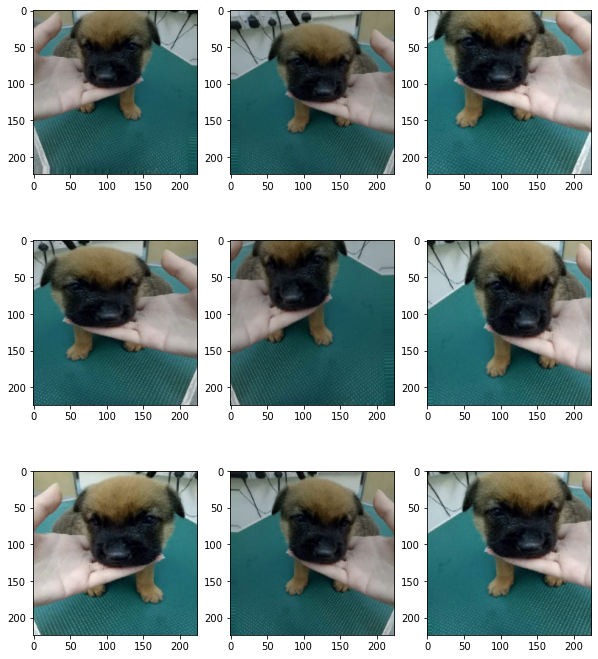

In [8]:
series = data.iloc[2]
data_augmentation_viz = pd.concat([series, series], axis=1).transpose()
iterator_visualizations = train_generator.flow_from_dataframe(
    dataframe=data_augmentation_viz,
    directory=dataset_dir,
    x_col="filename",
    y_col="Pawpularity",
    class_mode="raw",
    target_size=(width, height),
    batch_size=1,  # 1 seule image pour vérifier
)
plt.figure(figsize=(10, 12))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)  # 3x3 grid
    batch = next(iterator_visualizations)  # toujours la même image
    img = batch[0]
    img = img[0, :, :, :]
    plt.imshow(img)
plt.show()
plt.close()

In [8]:
train_generator = train_generator.flow_from_dataframe(
    dataframe=train,
    directory=dataset_dir,
    x_col="filename",
    y_col="Pawpularity",
    class_mode="raw",  # "raw" pour les regressions
    target_size=(width, height),
    batch_size=batch_size
)
validation_generator = validation_generator.flow_from_dataframe(
    dataframe=val,
    directory=dataset_dir,
    x_col="filename",
    y_col="Pawpularity",
    class_mode="raw",
    target_size=(width, height),
    batch_size=batch_size
)
test_generator = test_generator.flow_from_dataframe(
    dataframe=test,
    directory=dataset_dir,
    x_col="filename",
    y_col="Pawpularity",
    class_mode="raw",
    target_size=(width, height),
    batch_size=batch_size
)

Found 7136 validated image filenames.
Found 1983 validated image filenames.
Found 793 validated image filenames.


In [10]:
early_stopping_callback = EarlyStopping(
    monitor="val_mean_absolute_percentage_error",
    min_delta=1,  # sous les 1% de mieux, on patiente
    patience=10,  # on patiente max 10 epochs
    verbose=2,
    mode="min",
    restore_best_weights=True
)
model_checkpoint_callback = ModelCheckpoint(
    'efficientNet_reg.h5',
    monitor="val_mean_absolute_percentage_error",
    verbose=0,
    save_best_only=True,
    mode="min",
    save_freq="epoch"
)
callbacks = [early_stopping_callback, model_checkpoint_callback]

In [9]:
efficientnet = EfficientNetB0(include_top=False, weights='imagenet',
                              input_shape=(height, width, 3))
for layer in efficientnet.layers:
        layer.trainable = False

x = GlobalAveragePooling2D(name="avg_pool")(efficientnet.output)
x = BatchNormalization()(x)
top_dropout_rate = 0.4
x = Dropout(top_dropout_rate, name="top_dropout")(x)
outputs = Dense(1, name="pred")(x)

efficientnet = Model(inputs=efficientnet.inputs, outputs=outputs)

radam = tfa.optimizers.RectifiedAdam(learning_rate=0.001)
optimizer = tfa.optimizers.Lookahead(radam, sync_period=6, slow_step_size=0.5)

efficientnet.compile(
    optimizer=optimizer,
    loss="mean_absolute_error",
    metrics=[MeanAbsoluteError(), MeanAbsolutePercentageError()]
)

16719872/16705208 [==============================] - 0s 0us/step


In [12]:
epochs = 100
batch_size = 8
history_efficientnet = efficientnet.fit(
    train_generator,
    epochs=epochs,
    validation_data=validation_generator,
    callbacks=callbacks,
    workers=6  # guess
)

Epoch 1/100
223/223 [==============================] - ETA: 0s - loss: 37.5020 - mean_absolute_error: 37.5020 - mean_absolute_percentage_error: 98.2010

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


223/223 [==============================] - 100s 379ms/step - loss: 37.5020 - mean_absolute_error: 37.5020 - mean_absolute_percentage_error: 98.2010 - val_loss: 37.2925 - val_mean_absolute_error: 37.2925 - val_mean_absolute_percentage_error: 95.3601
Epoch 2/100
223/223 [==============================] - 85s 375ms/step - loss: 34.8135 - mean_absolute_error: 34.8135 - mean_absolute_percentage_error: 88.8854 - val_loss: 32.1483 - val_mean_absolute_error: 32.1483 - val_mean_absolute_percentage_error: 79.9343
Epoch 3/100
223/223 [==============================] - 86s 377ms/step - loss: 24.8236 - mean_absolute_error: 24.8236 - mean_absolute_percentage_error: 67.1280 - val_loss: 17.4262 - val_mean_absolute_error: 17.4262 - val_mean_absolute_percentage_error: 55.3876
Epoch 4/100
223/223 [==============================] - 84s 371ms/step - loss: 15.5059 - mean_absolute_error: 15.5059 - mean_absolute_percentage_error: 63.8216 - val_loss: 14.8889 - val_mean_absolute_error: 14.8889 - val_mean_absolu

In [20]:
train["Pawpularity"].mean()

37.943385650224215

In [12]:
mean_baseline = MeanAbsolutePercentageError()
mean_baseline = mean_baseline(
    val["Pawpularity"], train["Pawpularity"].mean()
).numpy()

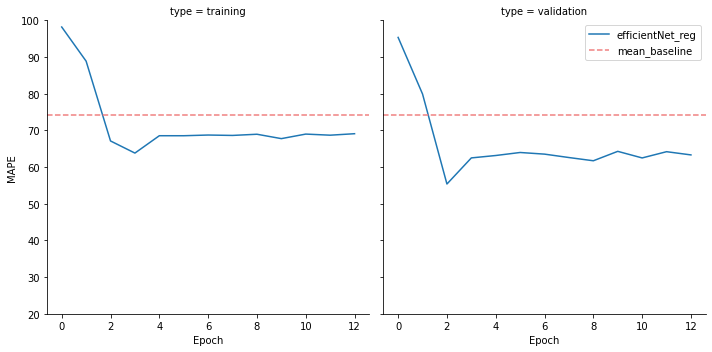

In [23]:
dict1 = {
    "MAPE": history_efficientnet.history["mean_absolute_percentage_error"],
    "type": "training"
}
dict2 = {
    "MAPE": history_efficientnet.history["val_mean_absolute_percentage_error"],
    "type": "validation"
}
s1 = pd.DataFrame(dict1)
s2 = pd.DataFrame(dict2)
df = pd.concat([s1, s2], axis=0).reset_index()
import seaborn as sns
grid = sns.relplot(
    data=df,
    x=df["index"],
    y="MAPE",
    col="type",
    kind="line",
    legend=False
)
grid.set(ylim=(20, 100))
for ax in grid.axes.flat:
    ax.axhline(
        y=mean_baseline, color="lightcoral", linestyle="dashed"
    )
    ax.set(xlabel="Epoch")
plt.legend(labels=["efficientNet_reg", "mean_baseline"])
plt.show()

In [10]:
def show_perfs(history, epochs):
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs_range = range(epochs)
    plt.figure(figsize=(8, 8))
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

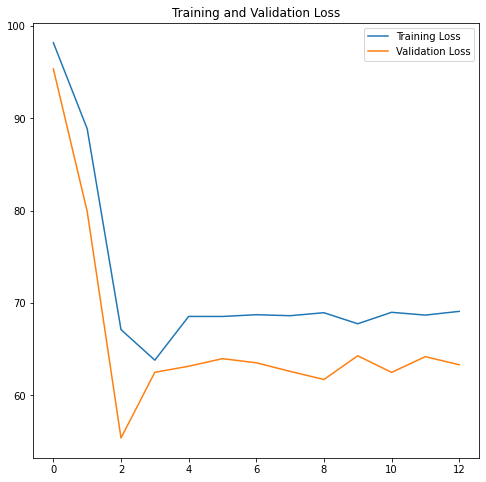

In [28]:
show_perfs(history_efficientnet, 13)

pawpularity= 35 	prediction= 24.39
pawpularity= 51 	prediction= 24.42
pawpularity= 21 	prediction= 24.39
pawpularity= 42 	prediction= 24.4
pawpularity= 29 	prediction= 24.39
pawpularity= 60 	prediction= 24.4
pawpularity= 40 	prediction= 24.41
pawpularity= 33 	prediction= 24.4
pawpularity= 64 	prediction= 24.38
pawpularity= 30 	prediction= 24.39
pawpularity= 25 	prediction= 24.41
pawpularity= 27 	prediction= 24.41


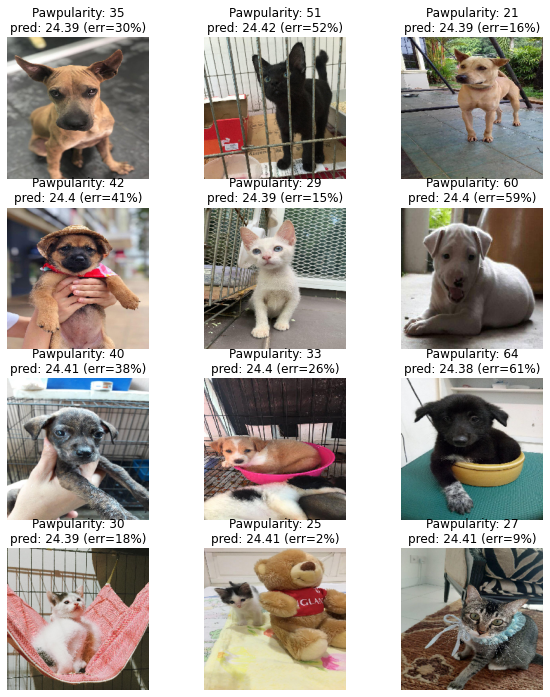

In [54]:
plt.figure(figsize=(10, 12))
batch = next(test_generator)  # renvoie 32 images
for i in range(12):
    ax = plt.subplot(4, 3, i + 1)  # 4x3 grid
    image = batch[0][i, :, :, :]  # i-ème image
    img = image.reshape(1, 224, 224, 3)  # reshape pour efficientnet
    pawpularity = batch[1][i]  # i-ème pawpularity
    preds = efficientnet.predict(img)
    prediction = preds.flatten()[0]
    print('pawpularity=', pawpularity, '\tprediction=', round(prediction, 2))
    diff = prediction - pawpularity
    percentDiff = (diff / pawpularity) * 100
    absPercentDiff = np.abs(percentDiff)
    plt.title("Pawpularity: " + str(pawpularity) +\
              "\npred: " + str(round(prediction, 2)) +\
              " (err=" + str(int(absPercentDiff)) + "%)")
    plt.imshow(image)
    plt.axis("off")
plt.show()
plt.close()

Je relance un entrainement, sans les callbacks

In [11]:
epochs = 100
history_efficientnet = efficientnet.fit(
    train_generator,
    epochs=epochs,
    validation_data=validation_generator,
    workers=8
)

Epoch 1/100
223/223 [==============================] - 353s 1s/step - loss: 37.4993 - mean_absolute_error: 37.4993 - mean_absolute_percentage_error: 98.2029 - val_loss: 37.3194 - val_mean_absolute_error: 37.3194 - val_mean_absolute_percentage_error: 95.4629
Epoch 2/100
223/223 [==============================] - 90s 387ms/step - loss: 34.8064 - mean_absolute_error: 34.8064 - mean_absolute_percentage_error: 88.8461 - val_loss: 32.4457 - val_mean_absolute_error: 32.4457 - val_mean_absolute_percentage_error: 80.6574
Epoch 3/100
223/223 [==============================] - 88s 386ms/step - loss: 24.8483 - mean_absolute_error: 24.8483 - mean_absolute_percentage_error: 67.8314 - val_loss: 17.8176 - val_mean_absolute_error: 17.8176 - val_mean_absolute_percentage_error: 55.4273
Epoch 4/100
223/223 [==============================] - 89s 389ms/step - loss: 15.5034 - mean_absolute_error: 15.5034 - mean_absolute_percentage_error: 63.6957 - val_loss: 14.8867 - val_mean_absolute_error: 14.8867 - val_me

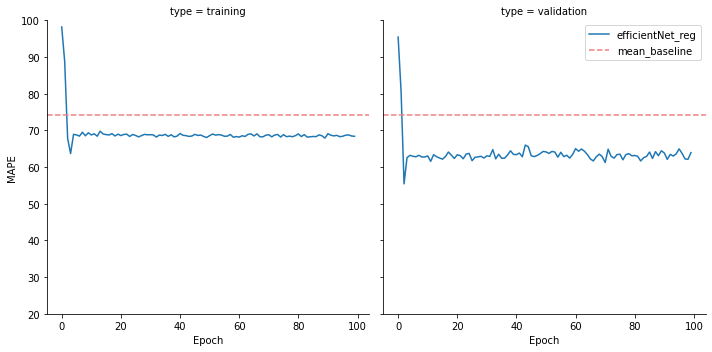

In [13]:
dict1 = {
    "MAPE": history_efficientnet.history["mean_absolute_percentage_error"],
    "type": "training"
}
dict2 = {
    "MAPE": history_efficientnet.history["val_mean_absolute_percentage_error"],
    "type": "validation"
}
s1 = pd.DataFrame(dict1)
s2 = pd.DataFrame(dict2)
df = pd.concat([s1, s2], axis=0).reset_index()
import seaborn as sns
grid = sns.relplot(
    data=df,
    x=df["index"],
    y="MAPE",
    col="type",
    kind="line",
    legend=False
)
grid.set(ylim=(20, 100))
for ax in grid.axes.flat:
    ax.axhline(
        y=mean_baseline, color="lightcoral", linestyle="dashed"
    )
    ax.set(xlabel="Epoch")
plt.legend(labels=["efficientNet_reg", "mean_baseline"])
plt.show()

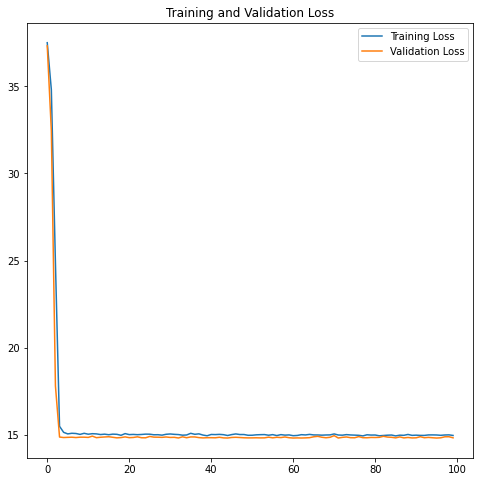

In [14]:
show_perfs(history_efficientnet, epochs)

pawpularity= 36 	prediction= 33.26
pawpularity= 38 	prediction= 33.29
pawpularity= 53 	prediction= 33.28
pawpularity= 41 	prediction= 33.26
pawpularity= 30 	prediction= 33.26
pawpularity= 50 	prediction= 33.25
pawpularity= 36 	prediction= 33.26
pawpularity= 30 	prediction= 33.29
pawpularity= 33 	prediction= 33.26
pawpularity= 22 	prediction= 33.26
pawpularity= 8 	prediction= 33.26
pawpularity= 23 	prediction= 33.25


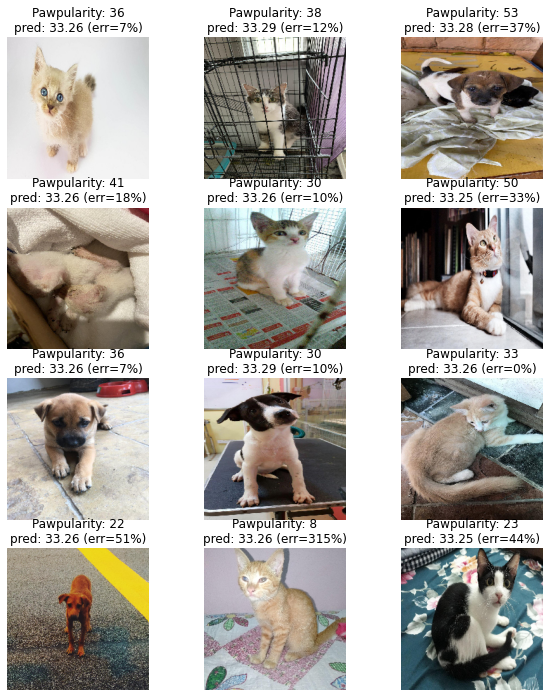

In [15]:
plt.figure(figsize=(10, 12))
batch = next(test_generator)  # renvoie 32 images
for i in range(12):
    ax = plt.subplot(4, 3, i + 1)  # 4x3 grid
    image = batch[0][i, :, :, :]  # i-ème image
    img = image.reshape(1, 224, 224, 3)  # reshape pour efficientnet
    pawpularity = batch[1][i]  # i-ème pawpularity
    preds = efficientnet.predict(img)
    prediction = preds.flatten()[0]
    print('pawpularity=', pawpularity, '\tprediction=', round(prediction, 2))
    diff = prediction - pawpularity
    percentDiff = (diff / pawpularity) * 100
    absPercentDiff = np.abs(percentDiff)
    plt.title("Pawpularity: " + str(pawpularity) +\
              "\npred: " + str(round(prediction, 2)) +\
              " (err=" + str(int(absPercentDiff)) + "%)")
    plt.imshow(image)
    plt.axis("off")
plt.show()
plt.close()